# Tools used

* Project Jupyter notebook
* Python
* Pandas library
* Open Street Map API
* Matplotlib
* Basemap
* Network X
* Open Data
* All pairs shortest path (Floyd-Warshall algorithm)

In [9]:
!sudo pip install pyshp

Downloading/unpacking pyshp
  Running setup.py (path:/tmp/pip_build_root/pyshp/setup.py) egg_info for package pyshp
    
    no previously-included directories found matching 'shapefiles'
  Running setup.py install for pyshp
    
    no previously-included directories found matching 'shapefiles'
Cleaning up...


In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import osmapi
import pandas as pd
import numpy as np
import shapefile #pyshp
import shapely
import networkx as nx
import sys
from shapely import geometry

In [3]:
# GATHER SHAPEFILES OF LOS ANGELES
# http://www.arcgis.com/home/item.html?id=7da35609c7604967bc2e99edf6b0100e
sf = shapefile.Reader("./LANeighborhoodCouncils/NeighborhoodCouncils.shp")

In [ ]:
# QUICK PLOT OF SHAPEFILES TO CONFIRM

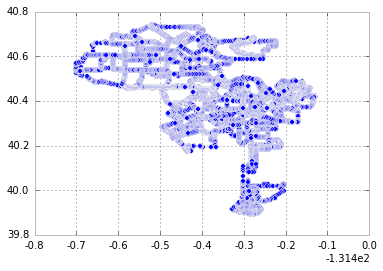

In [4]:
# MERGE INTO ONE LARGE SHAPE, MINKOWSKI SUM?

for i in range(0, len(sf.shapes())):
    shape = sf.shapes()[i]
    df = pd.DataFrame(shape.points)
    df.columns = ['lon', 'lat']
    plt.scatter(df.lon/10**5, df.lat/10**5)

plt.show()

In [5]:
df['lon'] = df['lon'] / 10 ** 5
df['lat'] = df['lat'] / 10 ** 5

In [6]:
# MERGE INTO ONE LARGE SHAPE, MINKOWSKI SUM?

min_lon = df.lon.min()
min_lat = df.lat.min()
max_lon = df.lon.max()
max_lat = df.lat.max()

min_lon = -119.0808
min_lat = 33.6592
max_lon = -117.7432
max_lat = 34.3808

min_lon = -118.4937
min_lat = 33.9223
max_lon = -118.1593
max_lat = 34.1013

In [7]:
# FROM OSM, GET ALL STREET DATA

oa = osmapi.OsmApi()

In [8]:
from lxml import etree
from collections import defaultdict
from io import StringIO, BytesIO

In [9]:
tree = etree.parse("sm_map.xml")

300171

In [10]:
node_counts = defaultdict(int)
r=tree.getroot()
r.get('generator')
children = r.getchildren()
for child in children:
    node_counts[child.tag] += 1

print(node_counts)

defaultdict(<type 'int'>, {'node': 300171, 'remark': 1, 'bounds': 1, 'note': 1, 'meta': 1, 'relation': 566, 'way': 44306})


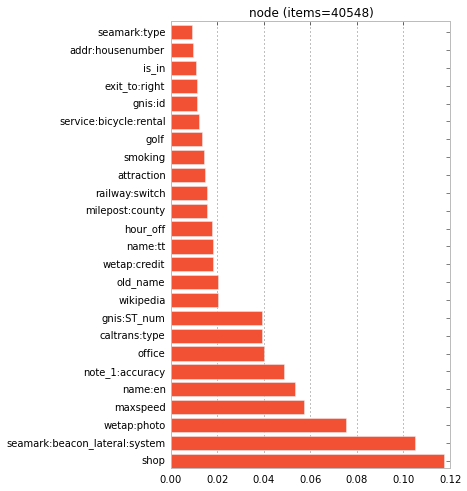

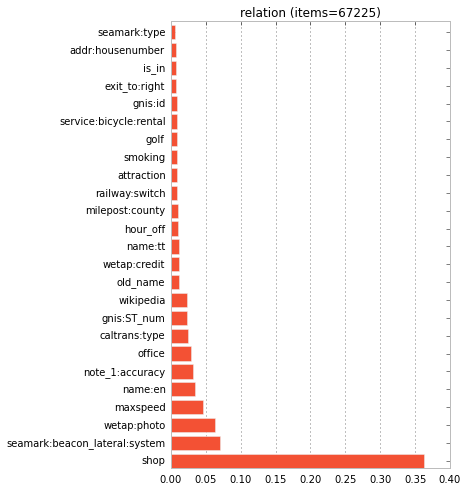

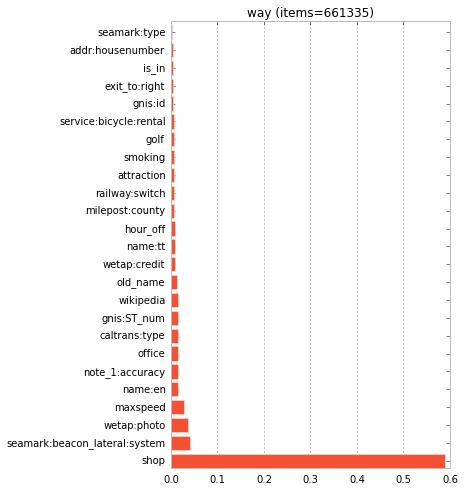

In [11]:
tags = {}
interesting = ['node', 'relation', 'way']
for interest in interesting:
    tags[interest] = defaultdict(int)

for child in children:
    tag = child.tag
    if tag == 'node' or tag == 'relation' or tag == 'way':
        tag_counts = tags[tag]
        gchildren = child.getchildren()
        for gchild in gchildren:
            key = gchild.get('k')
            tag_counts[key] += 1

keys = []
counts = []
for tc in tags.keys():
    tag_counts = tags[tc]
    for tag in tag_counts.keys():
        keys.append(tag)
        counts.append(tag_counts[tag])
    df = pd.DataFrame({'key': keys, 'count': counts})
    df.sort('count', ascending=0, inplace=True)
    n = 25
    x = np.arange(n)
    s = df['count'].sum()
    plt.figure(figsize=(5,8))
    plt.barh(x, df['count'][0:n]/s)
    plt.yticks(x+0.4, df['key'])
    plt.gca().yaxis.grid(False)
    plt.title(tc + ' (items=' + str(s) + ')')
    plt.show()

In [61]:
roads = {}
values = defaultdict(int)
children = r.getchildren()
for child in children:
    tag = child.tag
    if tag == 'way':
        gchildren = child.getchildren()
        for gchild in gchildren:
            k = gchild.get('k')
            if k=='highway':
                i = child.keys().index('id')
                road_id = child.values()[i]
                v = gchild.get('v')
                if v=='primary' or v=='secondary' or v=='tertiary' or v=='residential':
                    roads[road_id] = child
                values[v] += 1

In [14]:
def rec_print(elem, level=0):
    for i in range(level):
        sys.stdout.write('\t')
    sys.stdout.write(elem.tag)
    if elem.text is not None:
        sys.stdout.write(elem.text)
    ecount = 0
    for k in range(len(elem.keys())):
        key = elem.keys()[k]
        val = elem.values()[k]
        if ecount > 0:
            sys.stdout.write(';')
        sys.stdout.write(' ' + key + '=' + val)
        ecount += 1
    print ''
    for child in elem.getchildren():
        rec_print(child, level+1)

In [20]:
nodes = {}
children = r.getchildren()
for child in children:
    tag = child.tag
    if tag == 'node':
        ref = child.values()[child.keys().index('id')]
        lat = float(child.values()[child.keys().index('lat')])
        lon = float(child.values()[child.keys().index('lon')])
        nodes[ref] = [lat, lon]

In [122]:
def distance(n1, n2):
    lat1 = n1[0]
    lon1 = n1[1]
    lat2 = n2[0]
    lon2 = n2[1]
    return abs(lat1-lat2) + abs(lon1 - lon2)

In [123]:
g = nx.Graph()

intersection_check = defaultdict(list)

for road_id in roads.keys():
    road = roads[road_id]
    children = road.getchildren()
    ncount = 0
    for child in children:
        if child.tag=='nd':
            i = child.keys().index('ref')
            ref = child.values()[i]
            intersection_check[ref].append(road_id)

for road_id in roads.keys():
    road = roads[road_id]
    children = road.getchildren()
    ncount = 0
    name = '?'
    for child in children:
        if child.tag=='tag':
            i = child.keys().index('k')
            j = child.keys().index('v')
            k = child.values()[i]
            if k=='name':
                name = child.values()[j]
    for child in children:
        if child.tag=='nd':
            i = child.keys().index('ref')
            ref = child.values()[i]
            ic = intersection_check[ref]
            if len(ic) > 1:
                g.add_node(ref, {'label': name})
            else:
                g.add_node(ref, {'label': '[intersection]'})
            if ncount > 0:
                w = distance(nodes[ref], nodes[last_ref])
                g.add_edge(ref, last_ref, {'weight': w})
            ncount+=1
            last_ref = ref

In [120]:
[nodes[ref], nodes[last_ref]]


[[34.01562, -118.1861868], [34.01562, -118.1861868]]

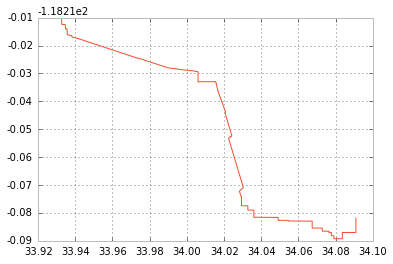

In [129]:
n1 = '3399262101'
n2 = '122682002'
path = nx.shortest_path(g, n1, n2)
npath = []
last = ''
lats = []
lons = []
for node in path:
    n = g.node[node]
    ll = nodes[node]
    lats.append(ll[0])
    lons.append(ll[1])
    label = n['label']
    if label != '[intersection]' and label != last:
        npath.append(label)
        last = label

plt.plot(lats, lons)
plt.show()

In [68]:
road_chains = {}
for rid in roads.keys():
    road = roads[rid]
    children = road.getchildren()
    for child in children:
        if child.tag == 'nd':
            print 'x'

In [65]:
g = nx.Graph()
keys = intersection_check.keys()
for key in keys:
    road_list = intersection_check[key]
    g.add_node(key)

    for rid in road_list:
        road = roads[rid]
    #if len(road_list) > 1:
    #    g.add_edge(?, ?)

len(g.nodes())

92189

In [69]:
road

<Element way at 0x7f59d7a50ea8>

In [70]:
rec_print(road)

way
     id=13304189; version=4; timestamp=2011-09-15T22:17:50Z; changeset=9312269; uid=28923; user=California Bear
	nd ref=122726421
	nd ref=122726424
	nd ref=122726427
	nd ref=122726428
	nd ref=1433929141
	tag k=highway; v=residential
	tag k=name; v=South Eastman Avenue
	tag k=tiger:cfcc; v=A41
	tag k=tiger:county; v=Los Angeles, CA
	tag k=tiger:name_base; v=Eastman
	tag k=tiger:name_direction_prefix; v=S
	tag k=tiger:name_type; v=Ave
	tag k=tiger:separated; v=no
	tag k=tiger:source; v=tiger_import_dch_v0.6_20070809
	tag k=tiger:tlid; v=141626100:141626113:141626088:141626097
	tag k=tiger:zip_left; v=90023
	tag k=tiger:zip_right; v=90023


In [49]:
len(g.nodes())

27144

In [36]:
intersection_check

defaultdict(<type 'list'>, {'14854412': ['3126730'], '1840702743': ['3126730'], '122909160': ['3126730'], '2258860933': ['3126730'], '2258860802': ['3126730'], '122727572': ['3126730'], '2258860790': ['3126730']})

In [22]:
rec_print(roads[0])

way
     id=3126730; version=25; timestamp=2013-04-08T21:07:55Z; changeset=15659696; uid=977071; user=nathansnider
	nd ref=14854412
	nd ref=2258860933
	nd ref=2258860802
	nd ref=2258860790
	nd ref=122727572
	nd ref=1840702743
	nd ref=122909160
	tag k=highway; v=primary
	tag k=lanes; v=5
	tag k=maxspeed; v=35 mph
	tag k=name; v=North Broadway
	tag k=source; v=survey;image;usgs_imagery
	tag k=source_ref; v=AM909_DSCR9625;AM909_DSCR9651


In [ ]:
# FROM OSM, GET ALL STREET DATA


In [ ]:
# alternatively, download from the web

In [33]:
#http://overpass-api.de/api/map?bbox=-119.0808,33.6626,-117.7432,34.3786
map = oa.Map(min_lon, min_lat, max_lon, max_lat)

ApiError: Request failed: 400 - Bad Request - 

map

In [ ]:
# VERIFICATION CELL

In [ ]:
# LOAD INTO NETWORK X

In [ ]:
# NAIVE DIRECTIONS

In [164]:
gchild.get('k')

'website'

In [167]:
# RETRIEVE GROCERY STORES
children = r.getchildren()
shop_types = defaultdict(int)
for child in children:
    tag = child.tag
    if tag == 'node':
        gchildren = child.getchildren()
        for gchild in gchildren:
            if gchild.tag == 'tag':
                k = gchild.get('k')
                v = gchild.get('v')
                if k == 'shop':
                    shop_types[v] += 1

shop_types
supermarket
grocery;butcher

defaultdict(<type 'int'>, {'smog_check': 1, 'outdoor': 2, 'bicycle': 23, 'shoes': 6, 'photo': 3, 'department_store': 9, 'newsagent': 1, 'hardware': 3, 'jewelry': 18, 'tobacco': 1, 'books': 7, 'video': 1, 'fabric': 1, 'toys': 2, 'florist': 6, 'art': 1, 'yes': 5, 'car_repair': 7, 'carpet': 1, 'tattoo': 1, 'grocery;butcher': 1, 'confectionery': 2, 'alcohol': 11, 'pet': 3, 'motorcycle': 1, 'bakery': 10, 'butcher': 2, 'sports': 4, 'paint': 1, 'music': 3, 'stationery': 3, 'electronics': 4, 'furniture': 11, 'drugstore': 1, 'garden_centre': 2, 'Thrift': 1, 'mobile_phone': 6, 'laundry': 6, 'beauty': 7, 'hairdresser': 10, 'deli': 4, 'automotive': 1, 'kiosk': 1, 'stationery;florist': 1, 'supermarket': 60, 'convenience;car_repair': 2, 'discount': 1, 'ice_cream': 1, 'greengrocer': 1, 'bank': 1, 'doityourself': 7, 'tyres': 1, 'wireless': 1, 'grocery': 1, 'copyshop': 2, 'optician': 2, 'gift': 13, 'luggage': 1, 'antiques': 1, 'car': 13, 'seafood': 2, 'vacant': 3, 'mall': 2, 'variety_store': 1, 'chemis

In [156]:
gchildren

[]

In [ ]:
# CALCULATE FOOD DESERT

In [ ]:
# FURTHEST FROM STARBUCKS

In [ ]:
# VISUALIZE